This project is a freelance job for a firm that makes snacks. Using `kmeans clustering`, it seeks to segment sales data according to Recency, Frequency, and Monetary Value (RFM). This will help the sales and marketing department better understand their clients, their purchasing power, and the type of sales campaign that will best satisfy their needs and increase sales.

I obtained the project's data from the company's sales department, cleaned it in Excel, and performed preprocessing with Python (Pandas). The preprocessed data is loaded for this ML project.

Note: Curreny is in Naira.

## Import Libraries

In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from datetime import timedelta


In [ ]:
# A function just to read, and modify data as needs be

def wrangle(filepath):

  df = pd.read_excel(filepath, parse_dates=True) # Read data

  df = df.rename(columns={'Amount' : 'Total_Sales'})

  # list unwanted rows
  rtf = ['Custom Pack - Cone', 'Custom Pack - Sticker', 'Caramel Popcorn 30g Pieces', 'Custom Pack - Box']

  # filter out unwanted rows
  mask2 = ~df['Product Name'].isin(rtf)
  df  = df[mask2]

  # filtering out the zero sales
  mask = df['Total_Sales'] != 0
  df = df[mask]

  # convert date to pandas datetime obj
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)



  return df

In [ ]:
# To ensure numerical data are formatted to 2 decimal place
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
# import data into a dataframe
df = wrangle('/content/Soyum_data.xlsx')
df.head()

,Date,Invoice_no,Customer_ID,Product Name,Qty,Total_Sales
2,2023-12-23,7092,633Oluch,Caramel Popcorn 30g Distributor,150,360000
3,2023-12-23,7091,736Sam I,Caramel Popcorn 55g Sub,100,600000
4,2023-12-22,7090,860EKERI,Caramel Popcorn 30g Sub,270,648000
5,2023-12-22,7089,633Oluch,Caramel Popcorn 55g Distributor,150,900000
6,2023-12-22,7088,179Yemsu,Caramel Popcorn 30g Sub,50,120000


# EDA

Exploratory data analysis will done just to check that we don't have missing values, data distribution and top customers and productlines

In [ ]:
df['Product Name'].unique()

array(['Caramel Popcorn 30g Distributor', 'Caramel Popcorn 55g Sub',
       'Caramel Popcorn 30g Sub', 'Caramel Popcorn 55g Distributor',
       'Caramel Popcorn 55g Retail', 'Caramel Popcorn 30g Retail',
       'Cinnamon Popcorn 50g Distributor',
       'Cinnamon Popcorn 30g Distributor', 'Cinnamon Popcorn 50g Retail',
       'Cinnamon Popcorn 30g Sub', 'Cinnamon Popcorn 50g Sub',
       'Cinnamon Popcorn 30g Retail'], dtype=object)

In [ ]:
df.isna().sum() # Checking to ensure I don't have missing values

,0
Date,0
Invoice_no,0
Customer_ID,0
Product Name,0
Qty,0
Total_Sales,0


In [ ]:
print(df.shape)
df.info()

(2353, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 2353 entries, 2 to 2490
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2353 non-null   datetime64[ns]
 1   Invoice_no    2353 non-null   int64         
 2   Customer_ID   2353 non-null   object        
 3   Product Name  2353 non-null   object        
 4   Qty           2353 non-null   int64         
 5   Total_Sales   2353 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 128.7+ KB


In [ ]:
df_int = df.select_dtypes(include='int')
df_int.describe()

,Invoice_no,Qty,Total_Sales
count,"2,353.00","2,353.00","2,353.00"
mean,"6,873.87",94.51,"295,885.79"
std,473.84,112.21,"310,656.35"
min,"6,010.00",1.00,"1,500.00"
25%,"6,462.00",15.00,"50,000.00"
50%,"6,898.00",50.00,"195,000.00"
75%,"7,283.00",120.00,"444,000.00"
max,"7,662.00",600.00,"1,998,000.00"


In [ ]:
# Top 10 customers in terms of total sales
df_top10 = (
    df.groupby(by='Customer_ID', as_index=False)['Total_Sales']
            .sum()
            .sort_values(by='Total_Sales', ascending=False)
            .head(10))
df_top10

,Customer_ID,Total_Sales
99,736Sam I,97858600
91,668Pauli,89461935
82,633Oluch,87007285
6,179Yemsu,67240010
11,205Iya A,47610500
85,657Yvonn,41321000
46,422Mrs S,27944050
113,828Offic,20374020
12,208Mrs P,16279005
103,757Prime,15621400


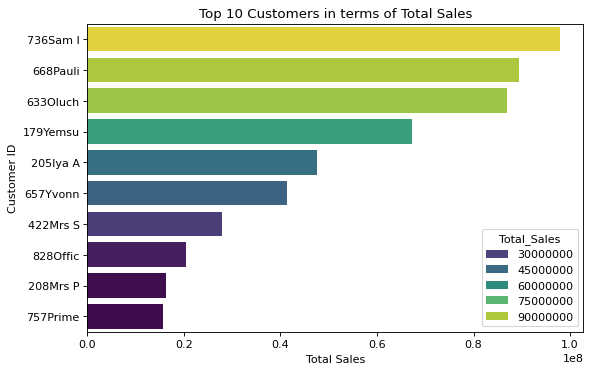

In [ ]:
# top10 customers visualisation
plt.figure(figsize=(8, 5), dpi=80)
sns.barplot(data=df_top10,
            x=df_top10.Total_Sales,
            y=df_top10.Customer_ID,
            palette='viridis', orient='h', hue='Total_Sales')
plt.title('Top 10 Customers in terms of Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Customer ID')
plt.show()

In [ ]:
# Top10 customers with productline
top_prodctline = (
    df.groupby(by=['Customer_ID', 'Product Name'], as_index=False)['Product Name']
    .value_counts()
    .sort_values(by='count', ascending=False)
    .head(10)
    )
top_prodctline

,Customer_ID,Product Name,count
198,668Pauli,Caramel Popcorn 30g Distributor,111
176,633Oluch,Caramel Popcorn 55g Distributor,104
174,633Oluch,Caramel Popcorn 30g Distributor,98
199,668Pauli,Caramel Popcorn 55g Distributor,90
252,828Offic,Caramel Popcorn 30g Sub,62
183,657Yvonn,Caramel Popcorn 30g Distributor,59
17,179Yemsu,Caramel Popcorn 30g Sub,56
217,736Sam I,Caramel Popcorn 55g Sub,52
255,828Offic,Caramel Popcorn 55g Sub,52
234,771Kolap,Caramel Popcorn 30g Sub,51


In [ ]:
fig = px.bar(top_prodctline,
             x='Customer_ID',
             y='count',
             color='Product Name',
             barmode='group')
fig.update_layout(title='Top 10 Selling Productlines',
                  xaxis_title='Customer ID',
                  yaxis_title='Productline Counts')
fig.show()

Customer id 144Paul leads with 30g pack as top selling point

# RFM Data Preparation

A. Aggregation

B. Data Distribution

C. Data Standardization


In [ ]:
# set a reference date to calculate recency
ref_date = df['Date'].max() + timedelta(days=1)
ref_date

Timestamp('2024-11-01 00:00:00')

In [ ]:
max_date = df['Date'].max()
max_date

Timestamp('2024-10-31 00:00:00')

## AGGREGATION

Here I will be aggregating base on;
1. volume of sales
2. last purchase date and
3. No of invoices issued

In [ ]:
# Aggregating to get RFM data
df_rfm = df.groupby(by='Customer_ID', as_index=False) \
          .agg(
              Last_purchase = ("Date", "max"),
              Frequency= ("Invoice_no", "nunique"),
              Monetary= ("Total_Sales", "sum")
              )
print(df_rfm.shape)
df_rfm.head()

(133, 4)


,Customer_ID,Last_purchase,Frequency,Monetary
0,101Am2Pm,2023-06-13,2,82420
1,106UGHUL,2024-09-05,16,5555200
2,116Tinua,2024-10-02,5,704000
3,142Out o,2024-05-27,9,1014500
4,158Soton,2024-09-20,15,4504000


In [ ]:
# calculating recency based on reference date
df_rfm["Recency"] = (ref_date - df_rfm['Last_purchase']).dt.days
df_rfm.head()

,Customer_ID,Last_purchase,Frequency,Monetary,Recency
0,101Am2Pm,2023-06-13,2,82420,507
1,106UGHUL,2024-09-05,16,5555200,57
2,116Tinua,2024-10-02,5,704000,30
3,142Out o,2024-05-27,9,1014500,158
4,158Soton,2024-09-20,15,4504000,42


## Data Distribution
Here, I will have to check for outliers|

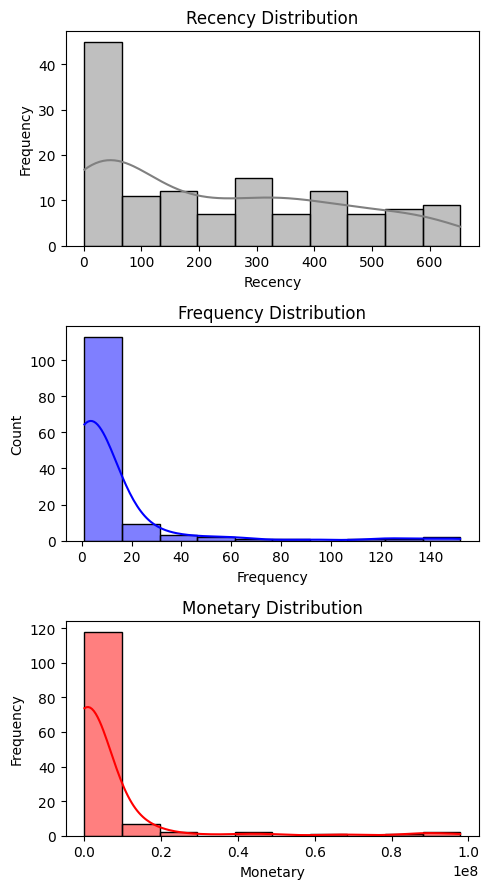

In [ ]:
# ploting distribution graph for RFM data

plt.figure(figsize=(5,9))

plt.subplot(3, 1, 1)
sns.histplot(df_rfm['Recency'], kde=True, bins=10, color='gray')
plt.title("Recency Distribution")
plt.xlabel("Recency")
plt.ylabel("Frequency")

plt.subplot(3, 1, 2)
sns.histplot(df_rfm['Frequency'], kde=True, bins=10, color='blue')
plt.title("Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")

plt.subplot(3, 1, 3)
sns.histplot(df_rfm['Monetary'], kde=True, bins=10, color='red')
plt.title("Monetary Distribution")
plt.xlabel("Monetary")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

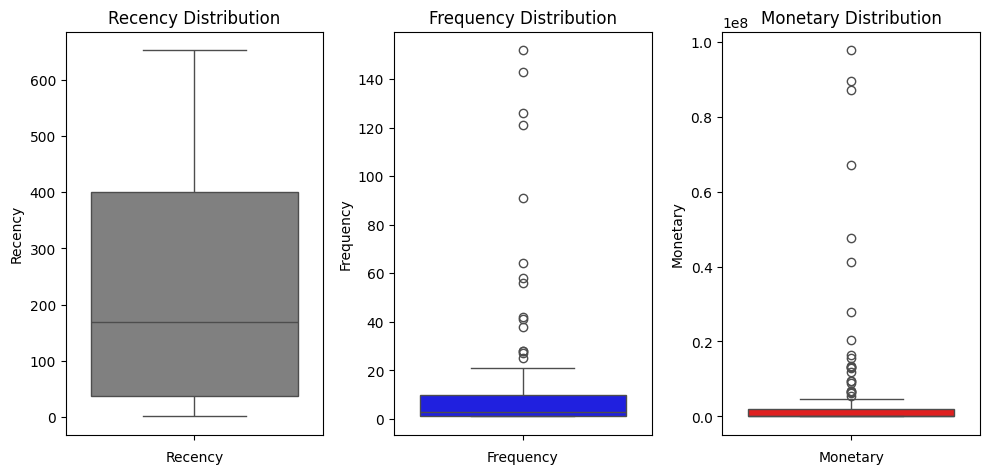

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
sns.boxplot(df_rfm['Recency'], color='gray')
plt.title("Recency Distribution")
plt.xlabel("Recency")


plt.subplot(1, 3, 2)
sns.boxplot(df_rfm['Frequency'], color='blue')
plt.title("Frequency Distribution")
plt.xlabel("Frequency")


plt.subplot(1, 3, 3)
sns.boxplot(df_rfm['Monetary'], color='red')
plt.title("Monetary Distribution")
plt.xlabel("Monetary")


plt.tight_layout()
plt.show()

From the graph over, it is clear that frequency and monetary values are highly skewed with outliers.

Outliers in this case are sets on clusters already.
But let's first consider our data without outliers by filtering out outliers

In [ ]:
# Geting outliers from the frequency column

freq_outlier_q1 = df_rfm['Frequency'].quantile(0.25) # quartile 1
freq_outlier_q3 = df_rfm['Frequency'].quantile(0.75) # quartile 3
freq_iqr = freq_outlier_q3 - freq_outlier_q1 # quartile difference (range)
freq_outlier_lower = freq_outlier_q1 - (1.5 * freq_iqr)
freq_outlier_higher = freq_outlier_q3 + (1.5 * freq_iqr)

freq_outlier = df_rfm[(df_rfm['Frequency'] < freq_outlier_lower) | (df_rfm['Frequency'] > freq_outlier_higher)]
freq_outlier.head()

,Customer_ID,Last_purchase,Frequency,Monetary,Recency
6,179Yemsu,2024-10-30,91,67240010,2
11,205Iya A,2024-10-30,41,47610500,2
12,208Mrs P,2024-10-31,42,16279005,1
15,230Adeol,2024-07-17,38,13524600,107
46,422Mrs S,2024-10-26,56,27944050,6


In [ ]:
# Geting outliers from the Monetary column

monetary_outlier_q1 = df_rfm['Monetary'].quantile(0.25)
monetary_outlier_q3 = df_rfm['Monetary'].quantile(0.75)
monetary_iqr = monetary_outlier_q3 - monetary_outlier_q1
monetary_outlier_lower = monetary_outlier_q1 - (1.5 * monetary_iqr)
monetary_outlier_higher = monetary_outlier_q3 + (1.5 * monetary_iqr)

Monetary_outlier = df_rfm[(df_rfm['Monetary'] < monetary_outlier_lower) | (df_rfm['Monetary'] > monetary_outlier_higher)]
Monetary_outlier.head()

,Customer_ID,Last_purchase,Frequency,Monetary,Recency
1,106UGHUL,2024-09-05,16,5555200,57
6,179Yemsu,2024-10-30,91,67240010,2
7,1811st J,2023-09-22,19,13230350,406
9,198CNGWo,2024-09-12,18,6627500,50
11,205Iya A,2024-10-30,41,47610500,2


In [ ]:
print(freq_outlier.shape)
Monetary_outlier.shape

(15, 5)


(23, 5)

In [ ]:
# data after filtering outliers
cleaned_rfm = df_rfm.loc[(~df_rfm.index.isin(Monetary_outlier.index)) & (~df_rfm.index.isin(freq_outlier.index))]
print(cleaned_rfm.shape)
cleaned_rfm.head()

(109, 5)


,Customer_ID,Last_purchase,Frequency,Monetary,Recency
0,101Am2Pm,2023-06-13,2,82420,507
2,116Tinua,2024-10-02,5,704000,30
3,142Out o,2024-05-27,9,1014500,158
4,158Soton,2024-09-20,15,4504000,42
5,164ADENU,2023-07-27,1,20000,463


Let's see the data distribution again after filtering out major outliers

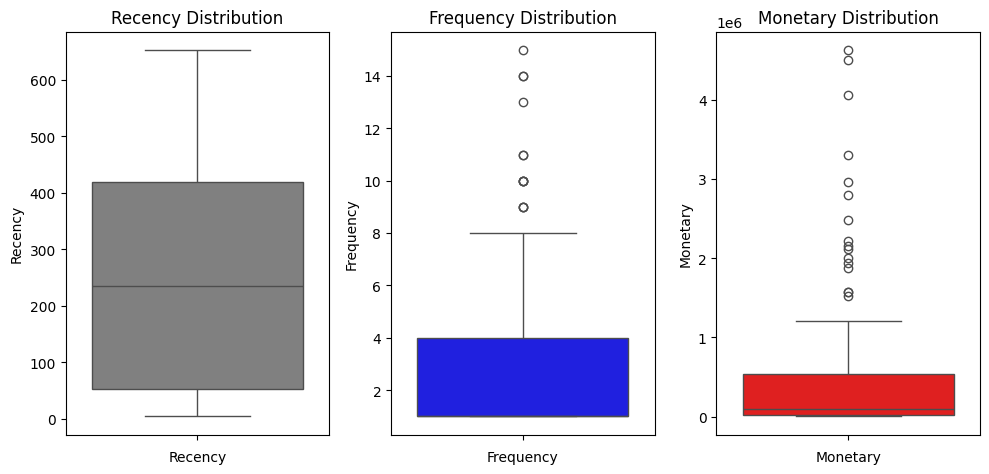

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
sns.boxplot(cleaned_rfm['Recency'], color='gray')
plt.title("Recency Distribution")
plt.xlabel("Recency")


plt.subplot(1, 3, 2)
sns.boxplot(cleaned_rfm['Frequency'], color='blue')
plt.title("Frequency Distribution")
plt.xlabel("Frequency")


plt.subplot(1, 3, 3)
sns.boxplot(cleaned_rfm['Monetary'], color='red')
plt.title("Monetary Distribution")
plt.xlabel("Monetary")


plt.tight_layout()
plt.show()

The distribution looks better now for both frequency and monetary

In [ ]:
cleaned_rfm.select_dtypes(exclude="datetime").describe()

,Frequency,Monetary,Recency
count,109.00,109.00,109.00
mean,3.38,"551,640.64",259.54
std,3.53,"977,643.41",204.33
min,1.00,"2,400.00",4.00
25%,1.00,"15,600.00",52.00
50%,1.00,"92,500.00",234.00
75%,4.00,"538,200.00",419.00
max,15.00,"4,634,250.00",653.00


STD of the monetary column is very high. I suspect it could have impact on the number of cluster we can have. Fingers crossed :(

In [ ]:
cleaned_rfm.head()

,Customer_ID,Last_purchase,Frequency,Monetary,Recency
0,101Am2Pm,2023-06-13,2,82420,507
2,116Tinua,2024-10-02,5,704000,30
3,142Out o,2024-05-27,9,1014500,158
4,158Soton,2024-09-20,15,4504000,42
5,164ADENU,2023-07-27,1,20000,463


## Data Standardization
Here I will have to standardize the data to avoid model from being baised when it encounters large numbers

In [ ]:
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(cleaned_rfm.select_dtypes(include="number"))
scaled_rfm[:5]

array([[-0.39167295, -0.48216758,  1.21664666],
       [ 0.46217408,  0.15656332, -1.12855446],
       [ 1.60063677,  0.47563077, -0.49923424],
       [ 3.30833081,  4.06141455, -1.06955569],
       [-0.67628862, -0.5463099 ,  1.00031784]])

In [ ]:
df_scaled = pd.DataFrame(scaled_rfm,
                         columns=cleaned_rfm.select_dtypes(include="number").columns,
                         index=cleaned_rfm.index)
df_scaled.head()

,Frequency,Monetary,Recency
0,-0.39,-0.48,1.22
2,0.46,0.16,-1.13
3,1.60,0.48,-0.50
4,3.31,4.06,-1.07
5,-0.68,-0.55,1.00


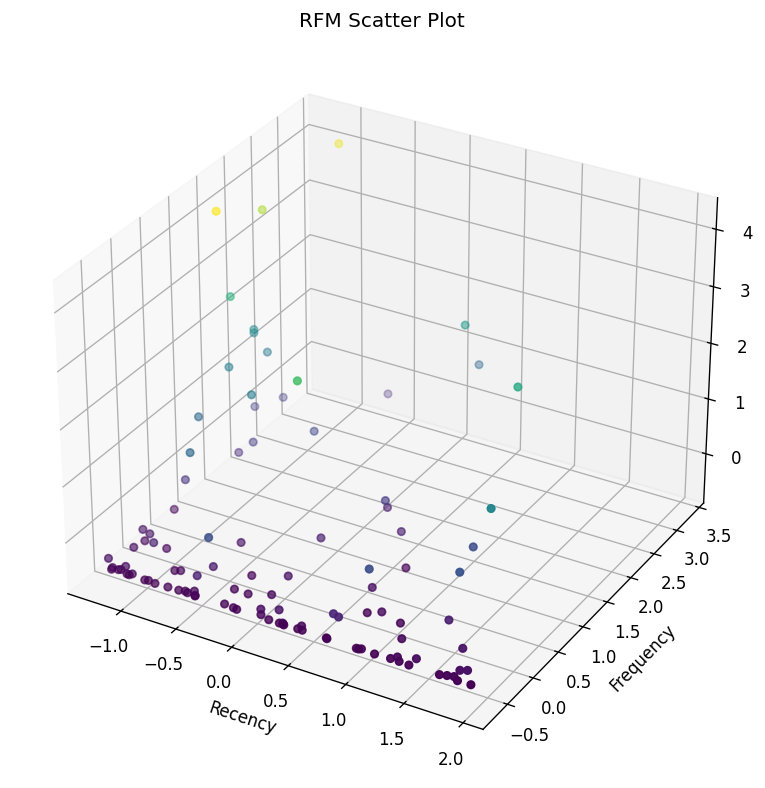

In [ ]:
# Visualisation of standardized RFM on a 3D plot
plt.figure(figsize=(12, 8), dpi=120)

ax = plt.subplot(projection='3d')
ax.scatter(df_scaled['Recency'],
           df_scaled['Frequency'],
           df_scaled['Monetary'], c=df_scaled['Monetary'], cmap='viridis')
ax.set_title('RFM Scatter Plot')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

# Pre-Modelling

Here, I will be training the model with different values of clusters, while appending their silouette scores and inertia values. This will enable me to choose the optimum cluster number using the elbow plow and the best siloutte score.

In [ ]:
clusters_max = 12
inertia = []
sil = []

for i in range(2, clusters_max + 1):
  kmodel = KMeans(n_clusters=i, max_iter=1000, random_state=42)
  kmodel.fit_predict(df_scaled)

  sil.append(silhouette_score(df_scaled, kmodel.labels_))
  inertia.append(kmodel.inertia_)


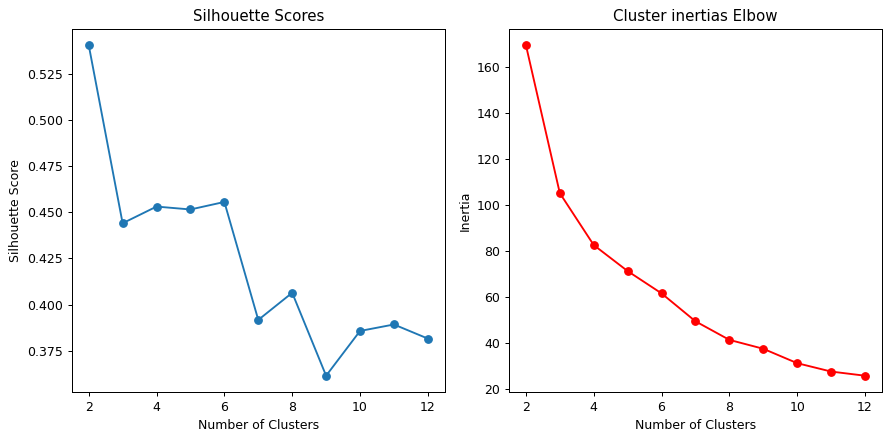

In [ ]:
plt.figure(figsize=(10, 5), dpi=90)

# silhoutte score plot
plt.subplot(1, 2, 1)
plt.plot(range(2, clusters_max + 1), sil, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Elbow plot using inertia and varied no of clusters
plt.subplot(1, 2, 2)
plt.plot(range(2, clusters_max + 1), inertia, marker='o', color='red')
plt.title('Cluster inertias Elbow')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.tight_layout()
plt.show()

Though using 6 clusters will give a better silhouette score, but considering the volume of my dataset, I decided to go with 4 clusters, so as to have a meeaningful clusters.

# K-Means Clustering
Performing the main clustering using kmeans

In [ ]:
model = KMeans(n_clusters=5, max_iter=1000, random_state=42)
labels = model.fit_predict(df_scaled)

labels[:5]

array([1, 0, 4, 2, 1], dtype=int32)

In [ ]:
#Adding clusters label to the dataframe
cleaned_rfm['Cluster_labels'] = labels
cleaned_rfm.tail()

<ipython-input-33-b35e2cf43a23>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Customer_ID,Last_purchase,Frequency,Monetary,Recency,Cluster_labels
128,928Belov,2024-06-04,1,24000,150,0
129,932Yetun,2024-04-05,3,20500,210,0
130,962AUNT,2023-12-05,14,1570740,332,4
131,962Funmi,2023-05-22,1,13500,529,1
132,978AM2PM,2024-01-31,2,127500,275,0


## Unsupervised Cluster visualization

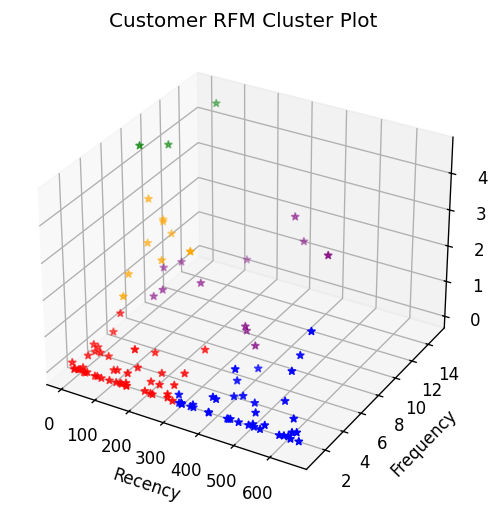

In [ ]:
color_to_use = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple'
}

colors = cleaned_rfm['Cluster_labels'].map(color_to_use)

plt.figure(figsize=(10, 5), dpi=120)

ax = plt.subplot(projection='3d')
ax.scatter(cleaned_rfm['Recency'],
           cleaned_rfm['Frequency'],
           cleaned_rfm['Monetary'],
           c=colors,
           marker="*")

ax.set_title('Customer RFM Cluster Plot')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

## Supervised Clustering

Now I have to manually set labels for frequency_outliers and monetary outliers.

There is also another cluster; the union between frequency and monetary outliers.

In total, 3 clusters will be added

In [ ]:
# identifying the intersection of the two outlier sets
outlier_intercept = Monetary_outlier.index.intersection(freq_outlier.index)
outlier_intercept

Index([6, 11, 12, 15, 46, 49, 82, 85, 91, 99, 103, 106, 113, 116], dtype='int64')

In [ ]:
# separating outliers into separate dataframes
monetary_frequency_outlier = Monetary_outlier.loc[outlier_intercept]
only_monetary_outlier = Monetary_outlier.drop(outlier_intercept)
only_freq_outlier = freq_outlier.drop(outlier_intercept)


In [ ]:
# labelling the supervised clusters
only_monetary_outlier['Cluster_labels'] = 5
only_freq_outlier['Cluster_labels'] = 6
monetary_frequency_outlier['Cluster_labels'] = 7

In [ ]:
# Merging supervised clusters into a dataframe
merged_outliers = pd.concat([monetary_frequency_outlier, only_monetary_outlier, only_freq_outlier])
merged_outliers.head()

,Customer_ID,Last_purchase,Frequency,Monetary,Recency,Cluster_labels
6,179Yemsu,2024-10-30,91,67240010,2,7
11,205Iya A,2024-10-30,41,47610500,2,7
12,208Mrs P,2024-10-31,42,16279005,1,7
15,230Adeol,2024-07-17,38,13524600,107,7
46,422Mrs S,2024-10-26,56,27944050,6,7


## Combined Clusters

In [ ]:
# merging both the unsupervised and supervised clusters
clustered_df = pd.concat([cleaned_rfm, merged_outliers])
clustered_df.head()

,Customer_ID,Last_purchase,Frequency,Monetary,Recency,Cluster_labels
0,101Am2Pm,2023-06-13,2,82420,507,1
2,116Tinua,2024-10-02,5,704000,30,0
3,142Out o,2024-05-27,9,1014500,158,4
4,158Soton,2024-09-20,15,4504000,42,2
5,164ADENU,2023-07-27,1,20000,463,1


## Cluster Analysis and Visualisation
Here are the results of the clustering.

I will be using boxplot to observe distributions of the different clusters.

Later, I will give my own opinion on the different clusters in the data.

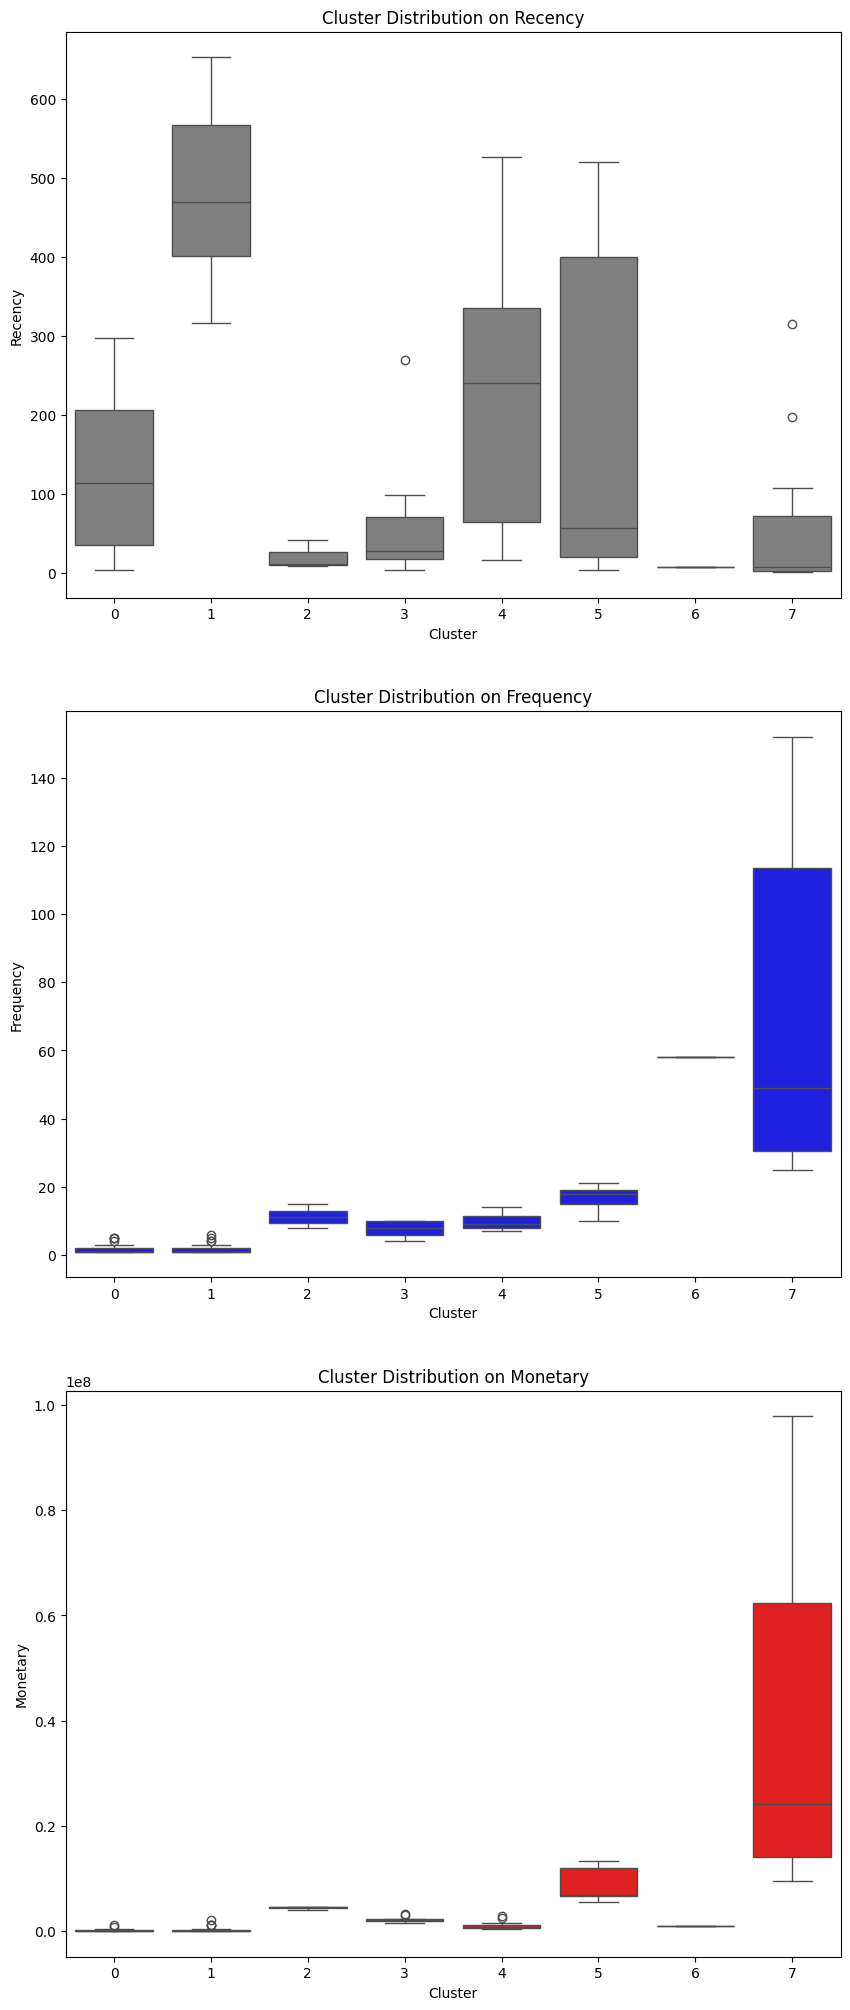

In [ ]:
plt.figure(figsize=(10, 25))

plt.subplot(3, 1, 1)
sns.boxplot(x=clustered_df['Cluster_labels'], y=clustered_df['Recency'], color='gray')
plt.title("Cluster Distribution on Recency")
plt.xlabel("Cluster")
plt.ylabel("Recency")

plt.subplot(3, 1, 2)
sns.boxplot(x=clustered_df['Cluster_labels'], y=clustered_df['Frequency'], color='blue')
plt.title("Cluster Distribution on Frequency")
plt.xlabel("Cluster")
plt.ylabel("Frequency")

plt.subplot(3, 1, 3)
sns.boxplot(x=clustered_df['Cluster_labels'], y=clustered_df['Monetary'], color='red')
plt.title("Cluster Distribution on Monetary")
plt.xlabel("Cluster")

plt.show()

I will like to see the correlation that exist between the 3 segmentations (RFM)

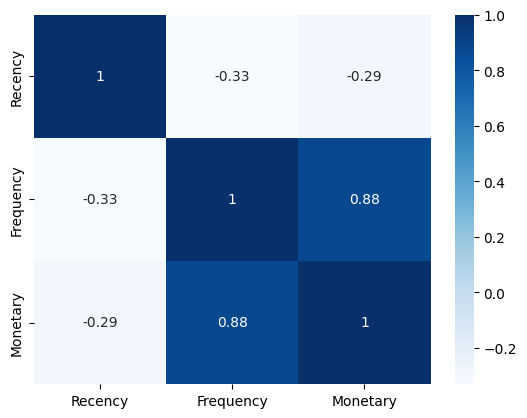

In [ ]:
corr = clustered_df[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()

Obviously, the higher the frequency, the higher the monetary value

### Cluster Interpretations and labelling (Subjective)

Cluster 0 ('Potential_Customers'): These are low-frequency, low-recent, and low-monetary clients. Gaining their trust in the product and figuring out how to increase sales are major tasks for the marketing department, if they are still in business. If properly nurtured, they can be viewed as a potential client.

Cluster 1 ('Brk_new_Ground'): This group of clients has a high degree of recentness, a little greater frequency than cluster 0, and a modest monetary contribution. Their low purchasing frequency accounts for their poor monetary value. Therefore, there is a chance that their financial contribution will increase if they make regular purchases. To improve their ability to contribute to sales, they must break new ground.

Cluster 2 ('Re-engage'): Both high and mid-low recency, low frequency, and low monetary. This suggests that even if they don't provide much money or frequently, some of them have lately made purchases where others are nearly lost. This customer has to be re-engaged by the marketing department.

Cluster 3('Special_order'): These are 'once in a blue moon' customers. They most likely just purchase for special orders or events. Once they are purchased, a substantial sum of money is contributed.

Cluster 4 ('Low_spenders'): Almost nothing was provided by this group. However, some people continue to buy new things.  it merits more investigation. Given the low purchase and low financial input, it is possible that they are low-spenders who adore the goods.

Cluster 5 ('Support'): One of our most important clients is this group. Their M and f are higher than those of clusters 1, 2, 3, and 4, despite their high recency, low frequency, and poor monetary value. To enhance their frequency, they require assistance. Support can include educating canvassers, promoting them, and assisting them in breaking new ground. Keep in mind that failure to act promptly could result in the loss of these clients.

Cluster 6 ('Special Offer'): These are everyday purchases of the cheapest or least expensive goods. They needed to be persuaded to purchase more expensive and larger quantities of goods. Offering promotions and exclusive deals will help you keep them.

'Die hard fans' are Cluster 7 ('Major_cust'). They are the company's lifeblood. They should be nurtured and rewarded. To guarantee their retention, there should be frequent assessments of their demands in addition to special discounts and other promotions. A small number of outliers require re-engagement.

In [ ]:
cluster_names = {
    0: 'Potential_Customers',
    1: 'Brk_new_Ground',
    2: 'Re-engage',
    3: 'Special_order',
    4: 'Low_spenders',
    5: 'Support',
    6: 'Special_Offer',
    7: 'Major_cust'
}

In [ ]:
clustered_df['Cluster_names_'] = clustered_df['Cluster_labels'].map(cluster_names)
clustered_df.head()

,Customer_ID,Last_purchase,Frequency,Monetary,Recency,Cluster_labels,Cluster_names_
0,101Am2Pm,2023-06-13,2,82420,507,1,Brk_new_Ground
2,116Tinua,2024-10-02,5,704000,30,0,Potential_Customers
3,142Out o,2024-05-27,9,1014500,158,4,Low_spenders
4,158Soton,2024-09-20,15,4504000,42,2,Re-engage
5,164ADENU,2023-07-27,1,20000,463,1,Brk_new_Ground


In [ ]:
clustered_df['monetary_in_thousandth'] = clustered_df['Monetary'] / 100000
clustered_df.head()

,Customer_ID,Last_purchase,Frequency,Monetary,Recency,Cluster_labels,Cluster_names_,monetary_in_thousandth
0,101Am2Pm,2023-06-13,2,82420,507,1,Brk_new_Ground,0.82
2,116Tinua,2024-10-02,5,704000,30,0,Potential_Customers,7.04
3,142Out o,2024-05-27,9,1014500,158,4,Low_spenders,10.14
4,158Soton,2024-09-20,15,4504000,42,2,Re-engage,45.04
5,164ADENU,2023-07-27,1,20000,463,1,Brk_new_Ground,0.20


In [ ]:
# export my clustered dataframe to csv for dash visualisation
clustered_df.to_csv('clustered_df.csv', index=False)

## Results Visualization

I will be looking at the combinations of both bar and line plots to visualize the results of the segmentation and clustering

In [ ]:
cluster_count = clustered_df['Cluster_names_'].value_counts()
cluster_count.head()

,count
Cluster_names_,
Potential_Customers,45
Brk_new_Ground,41
Special_order,20
Major_cust,14
Support,9


In [ ]:
cluster_grp = clustered_df.groupby(by='Cluster_names_')\
              [['Recency', 'Frequency', 'monetary_in_thousandth']].mean()

cluster_grp.head()

,Recency,Frequency,monetary_in_thousandth
Cluster_names_,,,
Brk_new_Ground,479.12,1.83,2.19
Major_cust,56.86,70.14,397.13
Potential_Customers,125.71,1.78,1.29
Re-engage,20.67,11.33,44.00
Special_Offer,7.00,58.00,8.77


In [ ]:
def cluster_data(df):
    df = df
    cluster_count = df['Cluster_names_'].value_counts()

    fig3 = px.bar(
        cluster_count,
        x=cluster_count.index,
        y=cluster_count.values,
        color = 'Cluster_names_'
    )
    fig3.update_layout(title='Customer Cluster Visualization',
                      xaxis_title='Cluster',
                      yaxis_title='Cluster Counts')
    return fig3

<ipython-input-100-23e08e31fcbe>:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



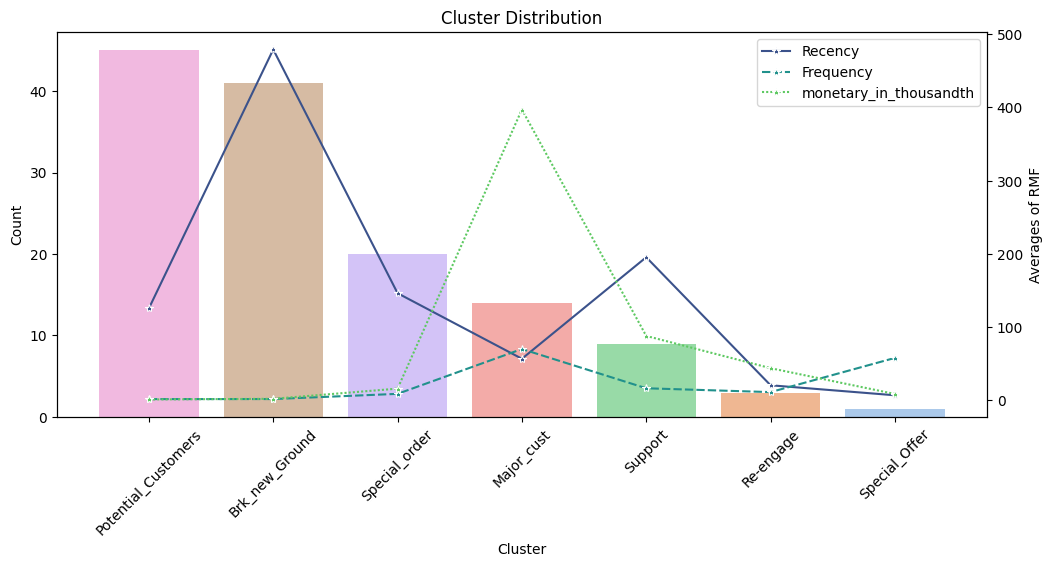

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(x=cluster_count.index,
            y=cluster_count.values,
            ax=ax,
            palette='pastel',
            hue =cluster_count.values)
ax.set_title('Cluster Distribution')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
ax.set_xticklabels(cluster_count.index, rotation=45)
ax.legend_.remove()

ax1 = ax.twinx()

sns.lineplot(data=cluster_grp, marker='*', palette='viridis', ax=ax1, color='red')
ax1.set_ylabel('Averages of RMF')



plt.show()

In conclusion, the company needs to undertake a lot of marketing and re-engagement. Re-engaging the majority of their customers was necessary.

Also, there aren't many significant factors that contribute to their monetary worth. Some of their underperforming consumers must be moved to the major customer group or the support group.
Their income growth will be improved by this.